# 10 Minutes to kanoa

This notebook provides a comprehensive introduction to **kanoa** - an AI-powered analytics interpreter.

## Features Covered

1. **Multi-Backend Support**: Gemini, Claude, and OpenAI (vLLM/Molmo/Gemma 3)
2. **Knowledge Base Integration**: Text and PDF support
3. **Matplotlib Figure Interpretation**: Direct visualization analysis
4. **DataFrame Analysis**: Tabular data interpretation
5. **Cost Tracking**: Token usage and cost monitoring
6. **Caching**: Efficient context reuse

---

## Setup

First, let's import the necessary libraries and set up our environment.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv

# Import kanoa
from kanoa import AnalyticsInterpreter

# Set plot style
plt.style.use("seaborn-v0_8-darkgrid")

# Load API keys from user config

config_dir = Path.home() / ".config" / "kanoa"
if (config_dir / ".env").exists():
    load_dotenv(config_dir / ".env")

print("✓ Setup complete!")

✓ Setup complete!


## 1. Basic Figure Interpretation with Gemini

Let's start with a simple example: interpreting a matplotlib figure using the Gemini backend.

Prerequisite: you will need to have your environment set up with access to Gemini 3.

see https://github.com/lhzn-io/kanoa/blob/main/docs/source/user_guide/authentication.md#gemini-google


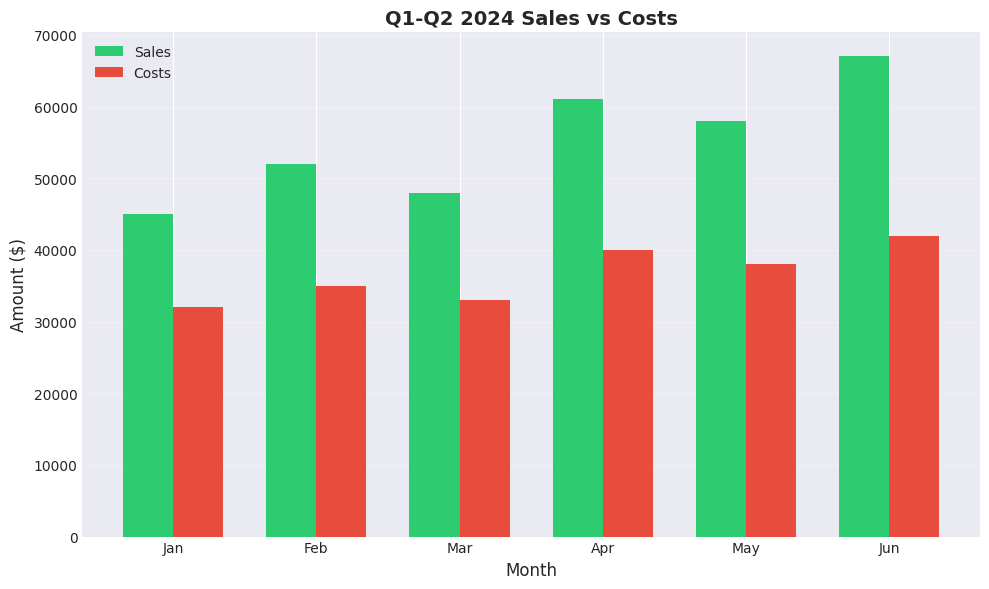

Figure created! Now let's interpret it...


In [2]:
# Create sample data
np.random.seed(42)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun"]
sales = [45000, 52000, 48000, 61000, 58000, 67000]
costs = [32000, 35000, 33000, 40000, 38000, 42000]

# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(months))
width = 0.35

ax.bar(x - width / 2, sales, width, label="Sales", color="#2ecc71")
ax.bar(x + width / 2, costs, width, label="Costs", color="#e74c3c")

ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Amount ($)", fontsize=12)
ax.set_title("Q1-Q2 2024 Sales vs Costs", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(months)
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("Figure created! Now let's interpret it...")

In [4]:
# Initialize interpreter with Gemini backend
gemini_interpreter = AnalyticsInterpreter(
    backend="gemini", model="gemini-2.5-flash", track_costs=True
)

# Interpret the figure
result = gemini_interpreter.interpret_figure(
    fig=fig,
    context="This shows our company's sales and costs for the first half of 2024",
    focus="Identify trends and calculate profit margins",
    display_result=True,
)


<div style="background: rgba(2, 62, 138, 0.08);
            border: 1px solid rgba(2, 62, 138, 0.3);
            border-left: 4px solid rgba(2, 62, 138, 0.8);
            padding: 16px 20px;
            margin: 10px 0;
            border-radius: 8px;
            backdrop-filter: blur(5px);
            box-shadow: 0 2px 8px rgba(0, 0, 0, 0.08);">

<div style="font-weight: 600; margin-bottom: 12px; opacity: 0.9; font-size: 1.05em; font-family: 'SF Mono', 'Monaco', 'Inconsolata', 'Fira Mono', 'Droid Sans Mono', 'Source Code Pro', monospace;">gemini</div>

Here's a technical interpretation of the "Q1-Q2 2024 Sales vs Costs" bar chart:

### 1. Summary

The provided bar chart visualizes the monthly Sales and Costs for the first two quarters (Q1-Q2) of 2024, spanning from January to June. Sales are represented by green bars, and Costs by red bars, with the Y-axis indicating the "Amount ($)". The purpose is to assess financial performance by comparing revenue generation against expenditures over this six-month period.

### 2. Key Observations

*   **Consistent Profitability**: In every month, Sales significantly exceed Costs, indicating consistent operational profitability.
*   **Overall Growth Trend**: Both Sales and Costs show a general upward trend from January to June, with notable growth observed in Q2 (April-June) compared to Q1 (January-March).
*   **Sales Performance**:
    *   Q1 Sales fluctuated: Jan (~$45k), Feb (~$52k), Mar (~$48k).
    *   Q2 Sales demonstrated stronger growth: Apr (~$61k), May (~$58k), Jun (~$67k). June recorded the highest sales.
*   **Cost Performance**:
    *   Costs generally mirrored sales fluctuations but at a lower scale: Jan (~$32k), Feb (~$35k), Mar (~$33k).
    *   Q2 Costs also increased: Apr (~$40k), May (~$38k), Jun (~$42k).
*   **Profit Margin Improvement**: The gap between Sales and Costs appears to widen in Q2, suggesting an improving profit margin over the period.

### 3. Technical Interpretation

We can calculate approximate monthly profits and profit margins to gain deeper insights:

| Month | Sales (Approx. $) | Costs (Approx. $) | Profit (Sales - Costs) (Approx. $) | Profit Margin (Profit / Sales) (Approx. %) |
| :---- | :---------------- | :---------------- | :------------------------------- | :---------------------------------------- |
| Jan   | 45,000            | 32,000            | 13,000                           | 28.9%                                     |
| Feb   | 52,000            | 35,000            | 17,000                           | 32.7%                                     |
| Mar   | 48,000            | 33,000            | 15,000                           | 31.3%                                     |
| **Q1 Total** | **145,000** | **100,000** | **45,000** | **31.0%** |
| Apr   | 61,000            | 40,000            | 21,000                           | 34.4%                                     |
| May   | 58,000            | 38,000            | 20,000                           | 34.5%                                     |
| Jun   | 67,000            | 42,000            | 25,000                           | 37.3%                                     |
| **Q2 Total** | **186,000** | **120,000** | **66,000** | **35.5%** |

*   **Profit Growth**: Monthly profit consistently increased from Jan to June, with June recording the highest profit of approximately $25,000. Q2 profits ($66k) significantly surpassed Q1 profits ($45k).
*   **Efficiency Improvement**: The profit margin shows an upward trend, starting at ~28.9% in January and reaching its peak at ~37.3% in June. This indicates that the company is becoming more efficient at converting sales into profit, or perhaps benefiting from economies of scale as sales volume increases, or a favorable shift in product mix with higher margins.
*   **Seasonal/Quarterly Patterns**: There's a clear upward shift in sales and profitability from Q1 to Q2. This could suggest seasonal demand patterns or successful Q2 initiatives.
*   **Cost Control**: While costs increased with sales, they did so at a slower rate, contributing to the improving profit margins. This implies effective cost management relative to sales growth.

### 4. Potential Issues

*   **Data Granularity**: The chart presents monthly aggregates. Deeper insights might be missed without daily or weekly data to identify intra-month patterns, anomalies, or specific event impacts.
*   **Cost Categorization**: All costs are lumped together. Understanding fixed vs. variable costs and their breakdown (e.g., COGS, operating expenses) would allow for more precise analysis of cost control and margin drivers.
*   **External Factors**: The analysis does not consider external market conditions, competitive landscape, or specific internal strategies (e.g., marketing campaigns, product launches) that might have influenced these trends.
*   **Approximation Errors**: Values are estimated from the bar heights, leading to minor inaccuracies in calculations.

### 5. Recommendations

1.  **Deep Dive into Q1 Dip (March)**: Investigate the reasons for the sales and profit dip in March compared to February, and if it was a planned or unexpected event.
2.  **Cost Structure Analysis**: Break down costs into relevant categories (e.g., Cost of Goods Sold, Marketing, Operations, Administrative) to identify which cost centers are driving the overall cost trends and where efficiencies are gained or lost.
3.  **Revenue Stream Analysis**: If applicable, segment sales by product line, region, or customer type to understand which revenue drivers are most profitable and contributing to the Q2 growth.
4.  **Forecasting & Budgeting**: Use these Q1-Q2 trends and profit margin improvements to refine sales and cost forecasts for Q3 and Q4, and to inform future budget allocations.
5.  **Benchmarking**: Compare these financial metrics against industry averages or previous years' performance to provide context on whether the growth and margins are competitive and sustainable.
6.  **Qualitative Context**: Gather qualitative information on any specific initiatives (e.g., new product launches, marketing campaigns, operational improvements) implemented during Q2 that could explain the observed uplift in sales and margins.

---
<small>**gemini-2.5-flash** · 1,920→1,399 tokens · $0.0206</small>

</div>


## 2. DataFrame Analysis

kanoa can also interpret tabular data directly.

In [5]:
# Create sample DataFrame
df = pd.DataFrame(
    {
        "Month": months,
        "Sales": sales,
        "Costs": costs,
        "Profit": [s - c for s, c in zip(sales, costs, strict=False)],
        "Margin_%": [(s - c) / s * 100 for s, c in zip(sales, costs, strict=False)],
    }
)

print("Financial Summary:")
display(df)

Financial Summary:


,Month,Sales,Costs,Profit,Margin_%
0,Jan,45000,32000,13000,28.888889
1,Feb,52000,35000,17000,32.692308
2,Mar,48000,33000,15000,31.250000
3,Apr,61000,40000,21000,34.426230
4,May,58000,38000,20000,34.482759
5,Jun,67000,42000,25000,37.313433


In [6]:
# Interpret the DataFrame
result = gemini_interpreter.interpret_dataframe(
    df=df,
    context="Monthly financial performance data",
    focus="Analyze profit trends and identify any concerning patterns",
    display_result=True,
)


<div style="background: rgba(2, 62, 138, 0.08);
            border: 1px solid rgba(2, 62, 138, 0.3);
            border-left: 4px solid rgba(2, 62, 138, 0.8);
            padding: 16px 20px;
            margin: 10px 0;
            border-radius: 8px;
            backdrop-filter: blur(5px);
            box-shadow: 0 2px 8px rgba(0, 0, 0, 0.08);">

<div style="font-weight: 600; margin-bottom: 12px; opacity: 0.9; font-size: 1.05em; font-family: 'SF Mono', 'Monaco', 'Inconsolata', 'Fira Mono', 'Droid Sans Mono', 'Source Code Pro', monospace;">gemini</div>

Here's a technical interpretation of the provided financial data:

1.  **Summary**:
    The output presents six months of sequential financial performance data, detailing sales revenue, associated costs, calculated net profit, and the resulting profit margin percentage for each month from January to June.

2.  **Key Observations**:
    *   **Sales Growth**: Revenue exhibits a strong, consistent upward trend, increasing from $45,000 in January to $67,000 in June.
    *   **Cost Growth**: Total costs also show an upward trend, generally increasing with sales, from $32,000 to $42,000 over the period.
    *   **Profit Growth**: Absolute profit demonstrates significant growth, more than doubling from $13,000 in January to $25,000 in June.
    *   **Margin Expansion**: The profit margin percentage (Profit/Sales) consistently expands, rising from 28.89% in January to 37.31% in June, indicating improved profitability per unit of sales.

3.  **Technical Interpretation**:
    The data indicates a **robust and improving financial performance** over the observed six-month period. The consistent growth in sales, coupled with a proportionally slower increase in costs, is driving a substantial increase in both absolute profit and the profit margin percentage. This suggests:
    *   **Positive Operating Leverage**: The business appears to be benefiting from positive operating leverage, where incremental revenue contributes a higher percentage to profit than previous revenue, leading to margin expansion. This could be due to fixed costs being spread over a larger revenue base, or variable costs increasing at a slower rate than revenue.
    *   **Enhanced Efficiency/Pricing Power**: The expanding profit margin indicates either improved operational efficiency (e.g., better cost control, economies of scale, optimized processes) or effective pricing strategies that are increasing the value captured per sale.
    *   **Scalability**: The trend suggests the business model is highly scalable, as revenue growth is translating into disproportionately higher profit growth.

4.  **Potential Issues**:
    *   **Limited Data Horizon**: Six months is insufficient to identify long-term trends, cyclical patterns (e.g., seasonality), or the impact of external market fluctuations.
    *   **Aggregated Cost Data**: The "Costs" are presented as a single figure. Without a breakdown (e.g., Cost of Goods Sold, operating expenses, marketing), it's impossible to pinpoint specific cost drivers or areas for targeted optimization.
    *   **Lack of Context**: Absence of historical performance data (e.g., prior year comparisons), budgetary targets, or industry benchmarks limits the ability to assess whether this performance is excellent, expected, or merely satisfactory.

5.  **Recommendations**:
    *   **Expand Time Series Analysis**: Extend the data to at least 12-24 months to account for seasonality and establish more reliable long-term trends.
    *   **Disaggregate Cost Structure**: Decompose the "Costs" into key components (e.g., variable vs. fixed, COGS, S&M, G&A) to identify specific drivers of efficiency gains or potential cost creep.
    *   **Variance and Benchmark Analysis**: Compare actual performance against budgeted figures, prior periods, and relevant industry benchmarks to provide critical context for performance evaluation.
    *   **Driver Analysis for Margin**: Investigate the specific factors contributing to the expanding profit margin (e.g., pricing adjustments, volume discounts, supply chain efficiencies, product mix changes).
    *   **Sensitivity Analysis**: Model the impact of potential changes in sales volume, pricing, or cost structure on future profitability and margin.

---
<small>**gemini-2.5-flash** · 313→779 tokens · $0.0100</small>

</div>


## 3. Knowledge Base Integration

Let's create a simple knowledge base and see how it enhances interpretations.

In [7]:
# Create a temporary knowledge base directory
import shutil
import tempfile

# Create a temporary directory that will be cleaned up automatically
# We assign it to a variable so it persists for the duration of the notebook
kb_temp_dir = tempfile.TemporaryDirectory()
kb_dir = Path(kb_temp_dir.name)

# Write domain knowledge
kb_content = """# Company Context

## Business Model
We are a SaaS company selling data analytics software to enterprise clients.

## Key Metrics
- Target profit margin: 35-40%
- Seasonal patterns: Q2 typically sees 15-20% growth over Q1
- Cost structure: 60% fixed costs, 40% variable

## Strategic Goals
- Maintain profit margins above 35%
- Achieve 10% month-over-month growth
- Keep cost growth below revenue growth
"""

with open(kb_dir / "company_context.md", "w") as f:
    f.write(kb_content)

print("✓ Knowledge base created!")

✓ Knowledge base created!


In [8]:
# Create a specialized interpreter with the knowledge base
# This shares the same backend and cost tracking as the original interpreter
gemini_interpreter_with_kb = gemini_interpreter.with_kb(
    kb_path=str(kb_dir), kb_type="text"
)

# Interpret with domain knowledge
result = gemini_interpreter_with_kb.interpret_dataframe(
    df=df,
    context="Monthly financial performance",
    focus="Evaluate performance against our strategic goals and industry benchmarks",
    display_result=True,
)


<div style="background: rgba(2, 62, 138, 0.08);
            border: 1px solid rgba(2, 62, 138, 0.3);
            border-left: 4px solid rgba(2, 62, 138, 0.8);
            padding: 16px 20px;
            margin: 10px 0;
            border-radius: 8px;
            backdrop-filter: blur(5px);
            box-shadow: 0 2px 8px rgba(0, 0, 0, 0.08);">

<div style="font-weight: 600; margin-bottom: 12px; opacity: 0.9; font-size: 1.05em; font-family: 'SF Mono', 'Monaco', 'Inconsolata', 'Fira Mono', 'Droid Sans Mono', 'Source Code Pro', monospace;">gemini</div>

Here's a technical interpretation of your monthly financial performance data:

## 1. Summary

The provided data covers six months (January to June) of sales, costs, profit, and profit margin for your SaaS company. It allows for an evaluation of performance against key strategic goals related to profit margins, revenue growth, and cost management, and comparison to seasonal patterns.

## 2. Key Observations

*   **Sales Growth:** Sales show an upward trend overall, starting at \$45,000 in January and reaching \$67,000 in June. There were dips in March and May after strong growth in February and April, respectively.
*   **Profit Margins:** Margins generally improved over the period, starting at 28.89% in January and reaching 37.31% in June.
*   **Costs:** Costs largely followed sales trends, increasing when sales grew and decreasing when sales dipped.
*   **Q2 Performance:** Sales in Q2 (Apr-Jun) significantly outperformed Q1 (Jan-Mar).

## 3. Technical Interpretation

Based on the company's strategic goals and context:

*   **Profit Margin Target (35-40%):** The company consistently underperformed the target margin for the first five months, with margins ranging from 28.89% to 34.48%. However, **June saw the profit margin hit 37.31%**, finally aligning with the strategic target. This indicates positive recent operational efficiency or pricing improvements.
*   **Month-over-Month (MoM) Growth (10%):**
    *   February (15.56%), April (27.08%), and June (15.52%) all **exceeded the 10% MoM sales growth target**.
    *   March (-7.69%) and May (-4.92%) both experienced **MoM sales contractions**, failing to meet the growth objective and indicating potential inconsistencies in sales cycles or market demand within Q1 and Q2.
*   **Cost Growth vs. Revenue Growth:**
    *   In February, April, May, and June, cost growth was effectively managed below revenue growth (or cost decline was greater than revenue decline in May), contributing positively to margin expansion.
    *   **In March, revenue declined by 7.69% while costs only declined by 5.71%**. This means costs did not shrink as rapidly as revenue, negatively impacting the profit margin for that month (31.25% down from 32.69% in Feb).
*   **Seasonal Patterns (Q2 vs Q1 Growth of 15-20%):**
    *   Total Q1 Sales (Jan-Mar): \$145,000
    *   Total Q2 Sales (Apr-Jun): \$186,000
    *   Q2 sales represent a **28.28% growth over Q1 sales**. This significantly **exceeds the target seasonal growth of 15-20%**, indicating very strong Q2 performance relative to historical patterns. This could be due to successful Q2 initiatives or a strong market.
*   **Cost Structure (60% fixed, 40% variable):** The behavior of costs, particularly in months with revenue declines (March and May), generally aligns with a mixed cost structure. For instance, in March, a revenue decline of 7.69% resulted in a smaller cost decline of 5.71%, which is expected with fixed costs. The variable cost component appears to be managed effectively to some

---
<small>**gemini-2.5-flash** · 462→778 tokens · $0.0103</small>

</div>


## 4. Multi-Backend Comparison

Let's compare interpretations across different backends.

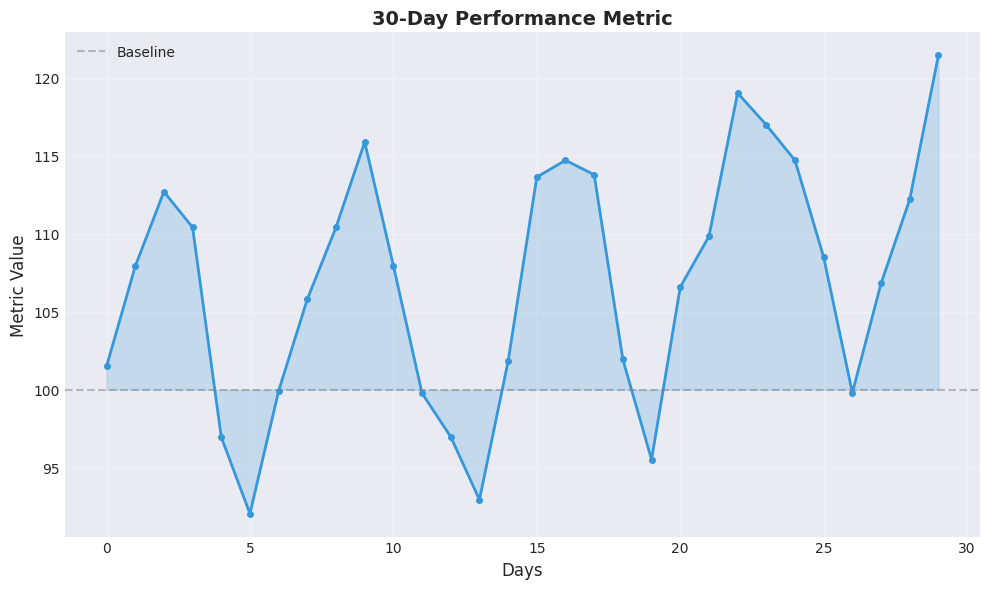

In [9]:
# Create a time series plot
fig2, ax2 = plt.subplots(figsize=(10, 6))

# Generate synthetic time series data
days = np.arange(30)
baseline = 100
trend = days * 0.5
seasonal = 10 * np.sin(2 * np.pi * days / 7)
noise = np.random.normal(0, 3, 30)
values = baseline + trend + seasonal + noise

ax2.plot(days, values, marker="o", linewidth=2, markersize=4, color="#3498db")
ax2.axhline(y=baseline, color="gray", linestyle="--", alpha=0.5, label="Baseline")
ax2.fill_between(days, baseline, values, alpha=0.2, color="#3498db")

ax2.set_xlabel("Days", fontsize=12)
ax2.set_ylabel("Metric Value", fontsize=12)
ax2.set_title("30-Day Performance Metric", fontsize=14, fontweight="bold")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.1 Gemini Interpretation

In [10]:
print("=" * 60)
print("GEMINI INTERPRETATION")
print("=" * 60)

gemini_result = gemini_interpreter.interpret_figure(
    fig=fig2,
    context="Daily performance metric tracking",
    focus="Identify trends, patterns, and anomalies",
    display_result=True,
)

GEMINI INTERPRETATION



<div style="background: rgba(2, 62, 138, 0.08);
            border: 1px solid rgba(2, 62, 138, 0.3);
            border-left: 4px solid rgba(2, 62, 138, 0.8);
            padding: 16px 20px;
            margin: 10px 0;
            border-radius: 8px;
            backdrop-filter: blur(5px);
            box-shadow: 0 2px 8px rgba(0, 0, 0, 0.08);">

<div style="font-weight: 600; margin-bottom: 12px; opacity: 0.9; font-size: 1.05em; font-family: 'SF Mono', 'Monaco', 'Inconsolata', 'Fira Mono', 'Droid Sans Mono', 'Source Code Pro', monospace;">gemini</div>

Here's a technical interpretation of the 30-Day Performance Metric chart:

### 1. Summary

The analytical output displays the daily performance metric over a 30-day period, charted against a static baseline of 100. The shaded area indicates periods where the metric value exceeded the baseline, providing a visual representation of "above-target" performance.

### 2. Key Observations

*   **Oscillatory Pattern**: The performance metric exhibits a strong, consistent oscillatory or cyclical pattern throughout the 30 days, with significant variations between peaks and troughs.
*   **Above Baseline Dominance**: For the majority of the 30-day period, the metric value remains above the baseline of 100. The shaded area visually confirms this dominance.
*   **Periodic Dips Below Baseline**: There are distinct periods where the metric falls below the baseline (e.g., around Day 4-6, Day 12-13, Day 18-19). These dips are relatively short-lived compared to the periods above the baseline.
*   **Peak and Trough Magnitudes**: Peak performance values reach as high as ~122 (Day 29), while troughs drop as low as ~92 (Day 5, Day 13). This indicates a substantial amplitude in the performance fluctuations.
*   **Increasing Trend in Peaks**: While oscillatory, there is a subtle increasing trend in the peak values over the 30 days, with the highest peak observed at the end of the period.
*   **Regularity**: The cycle length appears to be roughly 6-7 days from peak to peak or trough to trough.

### 3. Technical Interpretation

The observed oscillatory pattern strongly suggests an underlying cyclical process or external factor influencing the metric. This could be:
*   **Weekly Cycles**: If the "Days" axis represents calendar days, a 6-7 day cycle could correspond to weekly patterns (e.g., higher performance during weekdays, lower on weekends, or vice versa depending on the nature of the metric).
*   **Batch Processing/Deployment Cycles**: The metric might be tied to periodic system updates, data processing, or deployment schedules that cause temporary performance fluctuations.
*   **Resource Allocation/Demand Fluctuations**: Daily or weekly variations in resource availability or user demand could drive this pattern.
*   **Baseline as Target**: The baseline at 100 likely represents a target or satisfactory performance level. The metric spending significant time above this indicates generally good performance relative to the target. However, the dips below baseline signify periods of underperformance that warrant attention.
*   **Overall Improvement (Subtle)**: The increasing peak values, particularly towards the end of the period, might suggest a gradual underlying improvement trend despite the strong oscillations.

### 4. Potential Issues

*   **Unidentified Root Cause of Oscillations**: The primary concern is the lack of understanding of *why* the metric is oscillating so regularly and with such high amplitude. Without this understanding, it's difficult to proactively manage or optimize performance.
*   **Underperformance during Troughs**: The consistent drops below the baseline, even if brief, indicate periods where the system or process is not meeting its minimum performance targets. This could impact users or business operations.
*   **Potential for Misinterpretation**: If the oscillatory nature is not accounted for, a daily snapshot might be misleading (e.g., evaluating performance only on a peak day would be overly optimistic, while evaluating only on a trough day would be overly pessimistic).

### 5. Recommendations

1.  **Investigate Cyclical Factors**:
    *   **Overlay External Data**: Correlate the performance metric with known weekly schedules, deployment times, marketing campaigns, user activity patterns (e.g., daily active users, traffic), or other operational cycles.
    *   **Analyze Day-of-Week/Time-of-Day**: If available, break down the data by day of the week or even hour of the day to pinpoint specific periods of underperformance or peak performance.
2.  **Root Cause Analysis for Dips**: For each period the metric drops below 100, conduct a specific root cause analysis. Identify what changes, events, or conditions were present during those specific days (e.g., system load, errors, changes in code/configuration).
3.  **Trend Analysis Beyond Oscillations**: Apply time-series decomposition techniques to separate the trend, seasonality (oscillations), and residual components. This will help confirm if there's a true upward or downward trend in the *underlying* performance, independent of the cycles.
4.  **Define Acceptable Variance**: Establish control limits or acceptable variance around the baseline to better differentiate between expected fluctuations and true anomalies or significant underperformance.
5.  **Forecasting**: Once the cyclical component is understood, develop a forecasting model to predict future performance, enabling proactive resource allocation or intervention during anticipated dips.

---
<small>**gemini-2.5-flash** · 1,906→1,033 tokens · $0.0162</small>

</div>


### 4.2 Claude Interpretation

In [11]:
# Note: Requires ANTHROPIC_API_KEY environment variable
try:
    claude_interpreter = AnalyticsInterpreter(backend="claude", track_costs=True)

    print("=" * 60)
    print("CLAUDE INTERPRETATION")
    print("=" * 60)

    claude_result = claude_interpreter.interpret_figure(
        fig=fig2,
        context="Daily performance metric tracking",
        focus="Identify trends, patterns, and anomalies",
        display_result=True,
    )
except Exception as e:
    print(f"⚠️ Claude backend not available: {e}")
    print("Set ANTHROPIC_API_KEY to enable Claude backend.")

CLAUDE INTERPRETATION



<div style="background: rgba(2, 62, 138, 0.08);
            border: 1px solid rgba(2, 62, 138, 0.3);
            border-left: 4px solid rgba(2, 62, 138, 0.8);
            padding: 16px 20px;
            margin: 10px 0;
            border-radius: 8px;
            backdrop-filter: blur(5px);
            box-shadow: 0 2px 8px rgba(0, 0, 0, 0.08);">

<div style="font-weight: 600; margin-bottom: 12px; opacity: 0.9; font-size: 1.05em; font-family: 'SF Mono', 'Monaco', 'Inconsolata', 'Fira Mono', 'Droid Sans Mono', 'Source Code Pro', monospace;">claude</div>

# 30-Day Performance Metric Analysis

## 1. Summary
The chart displays a time-series performance metric tracked over 30 days against a baseline value of 100. The metric shows significant volatility with cyclical patterns, ranging from approximately 93 to 121.

## 2. Key Observations

### Volatility Patterns
- **High amplitude swings**: The metric fluctuates ±20% around the baseline
- **Cyclical behavior**: Appears to follow a ~7-day cycle with peaks and troughs
- **Three distinct peaks**: Days 2, 9, 16, and 22 show elevated performance (110-119)
- **Three notable troughs**: Days 5, 13, and 19 show significant dips (93-96)

### Trend Analysis
- **Weekly pattern**: Suggests potential correlation with day-of-week effects
- **Recent surge**: Days 28-30 show exceptional performance (113-121), representing the highest values in the period
- **Average performance**: Generally oscillates around the baseline with periods both above and below

## 3. Technical Interpretation

### Performance Characteristics
- **Periodicity**: The ~7-day cycle strongly suggests **weekly operational patterns** (e.g., weekday vs. weekend effects, batch processing schedules, or business cycle impacts)
- **Volatility coefficient**: Approximately 8-10% standard deviation indicates moderate but notable instability
- **Baseline crossings**: Frequent transitions above/below baseline (100) suggest responsive but unstable performance

### Statistical Insights
- The metric spends roughly equal time above and below baseline
- Standard deviation appears consistent throughout the period (no increasing/decreasing variance)
- End-of-period spike may indicate:
  - Month-end processing effects
  - System optimization implementation
  - Seasonal or calendar-driven demand

## 4. Potential Issues

### Data Quality Concerns
- **Sharp transitions**: Rapid day-to-day changes (e.g., day 4→5: 113→93) may indicate:
  - Measurement artifacts or sampling issues
  - System restarts or configuration changes
  - Natural operational variance

### Anomalies Identified
- **Day 30 spike** (121): Requires investigation—20% above baseline and highest recorded value
- **Consistent troughs**: Values dropping to 93-97 occur regularly; may represent capacity constraints or systematic bottlenecks
- **No sustained trend**: Lack of directional movement suggests either stable equilibrium or offsetting factors

## 5. Recommendations

### Immediate Actions
1. **Investigate the weekly cycle**: 
   - Overlay with calendar to identify day-of-week patterns
   - Compare with workload/traffic data to establish causation

2. **Analyze end-period surge**:
   - Determine if days 28-30 represent sustainable improvement or temporary spike
   - Review any system changes, optimizations, or external factors during this period

### Further Analysis
3. **Decompose the time series**:
   - Separate trend, seasonal, and residual components
   - Calculate autocorrelation to quantify the 7-day periodicity

4. **Establish control limits**:
   - Implement statistical process control (e.g., ±2σ or ±3σ bands)
   - Set alerts for values outside acceptable ranges

5. **Root cause analysis for troughs**:
   - Investigate why performance consistently drops below 95
   - Identify whether this represents capacity issues, resource contention, or operational constraints

6. **Extend monitoring window**:
   - Collect 60-90 days of data to confirm cyclical patterns
   - Enable month-over-month comparison

### Strategic Considerations
- If baseline (100) represents a performance target, current volatility indicates need for process stabilization
- Consider whether the cyclical pattern is acceptable for business requirements or requires mitigation
- The recent upward trend (if sustained) could inform capacity planning and resource allocation

---
<small>**claude-sonnet-4-5-20250929** · 916→904 tokens · $0.0163</small>

</div>


### 4.3 OpenAI / vLLM (Local) Interpretation

Connect to a local vLLM server hosting open-source models like **Ai2 Molmo** or **Gemma 3**.

This approach allows you to run powerful models on your own infrastructure (via `kanoa-mlops`) with full privacy.

In [ ]:
# Note: Requires local vLLM server running (see kanoa-mlops)
try:
    # Connect to local vLLM hosting Molmo or Gemma 3
    vllm_interpreter = AnalyticsInterpreter(
        backend="openai",
        api_base="http://localhost:8000/v1",
        model="allenai/Molmo-7B-D-0924",  # or 'google/gemma-3-12b-it'
        track_costs=True,
    )

    print("=" * 60)
    print("vLLM (Molmo/Gemma 3) INTERPRETATION")
    print("=" * 60)

    vllm_result = vllm_interpreter.interpret_figure(
        fig=fig2,
        context="Daily performance metric tracking",
        focus="Identify trends, patterns, and anomalies",
        display_result=True,
    )
except Exception as e:
    print(f"⚠️ vLLM backend not available: {e}")
    print("Ensure vLLM server is running on localhost:8000")

## 5. A More Complex Visualization

Let's test kanoa with a more complex multi-panel visualization.

/tmp/ipykernel_179978/285686976.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(data_groups, labels=["Group A", "Group B", "Group C", "Group D"])


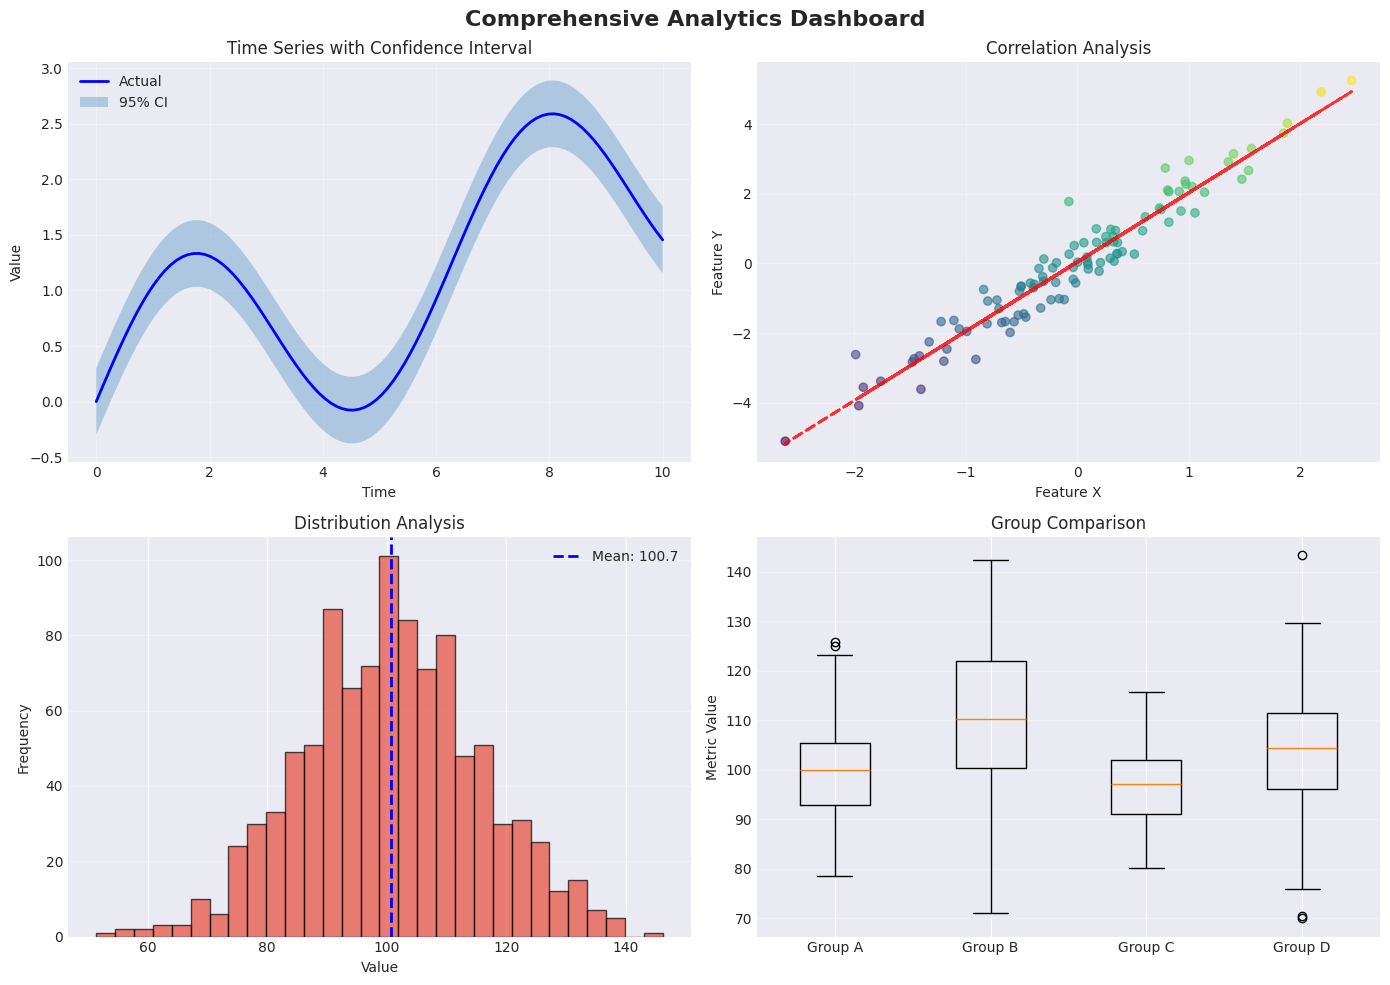

In [12]:
# Create complex multi-panel figure
fig3, axes = plt.subplots(2, 2, figsize=(14, 10))
fig3.suptitle("Comprehensive Analytics Dashboard", fontsize=16, fontweight="bold")

# Panel 1: Line plot with confidence interval
x = np.linspace(0, 10, 100)
y = np.sin(x) + x / 5
y_upper = y + 0.3
y_lower = y - 0.3

axes[0, 0].plot(x, y, "b-", linewidth=2, label="Actual")
axes[0, 0].fill_between(x, y_lower, y_upper, alpha=0.3, label="95% CI")
axes[0, 0].set_title("Time Series with Confidence Interval")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Value")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Panel 2: Scatter plot with trend
x_scatter = np.random.randn(100)
y_scatter = 2 * x_scatter + np.random.randn(100) * 0.5
axes[0, 1].scatter(x_scatter, y_scatter, alpha=0.6, c=y_scatter, cmap="viridis")
z = np.polyfit(x_scatter, y_scatter, 1)
p = np.poly1d(z)
axes[0, 1].plot(x_scatter, p(x_scatter), "r--", alpha=0.8, linewidth=2)
axes[0, 1].set_title("Correlation Analysis")
axes[0, 1].set_xlabel("Feature X")
axes[0, 1].set_ylabel("Feature Y")
axes[0, 1].grid(True, alpha=0.3)

# Panel 3: Distribution
data_dist = np.random.normal(100, 15, 1000)
axes[1, 0].hist(data_dist, bins=30, edgecolor="black", alpha=0.7, color="#e74c3c")
axes[1, 0].axvline(
    data_dist.mean(),
    color="blue",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {data_dist.mean():.1f}",
)
axes[1, 0].set_title("Distribution Analysis")
axes[1, 0].set_xlabel("Value")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis="y")

# Panel 4: Box plot comparison
data_groups = [
    np.random.normal(100, 10, 100),
    np.random.normal(110, 15, 100),
    np.random.normal(95, 8, 100),
    np.random.normal(105, 12, 100),
]
axes[1, 1].boxplot(data_groups, labels=["Group A", "Group B", "Group C", "Group D"])
axes[1, 1].set_title("Group Comparison")
axes[1, 1].set_ylabel("Metric Value")
axes[1, 1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

In [13]:
# Interpret the complex dashboard
result = gemini_interpreter.interpret_figure(
    fig=fig3,
    context="Multi-panel analytics dashboard showing various statistical analyses",
    focus="Provide a comprehensive interpretation of all four panels, highlighting key insights and relationships",
    display_result=True,
)


<div style="background: rgba(2, 62, 138, 0.08);
            border: 1px solid rgba(2, 62, 138, 0.3);
            border-left: 4px solid rgba(2, 62, 138, 0.8);
            padding: 16px 20px;
            margin: 10px 0;
            border-radius: 8px;
            backdrop-filter: blur(5px);
            box-shadow: 0 2px 8px rgba(0, 0, 0, 0.08);">

<div style="font-weight: 600; margin-bottom: 12px; opacity: 0.9; font-size: 1.05em; font-family: 'SF Mono', 'Monaco', 'Inconsolata', 'Fira Mono', 'Droid Sans Mono', 'Source Code Pro', monospace;">gemini</div>

This dashboard provides a comprehensive overview of various analytical insights across different data types and analyses.

### 1. Summary

The dashboard presents four distinct analytical views:
1.  **Time Series with Confidence Interval**: Illustrates a variable's evolution over time with associated predictive uncertainty.
2.  **Correlation Analysis**: Examines the linear relationship between two features.
3.  **Distribution Analysis**: Visualizes the frequency distribution of a single metric.
4.  **Group Comparison**: Compares the statistical properties (median, spread, outliers) of a metric across four different groups.

### 2. Key Observations

*   **Time Series with Confidence Interval**: The "Actual" time series exhibits a strong cyclical or oscillatory pattern, approximately sinusoidal, with a period of roughly 8 time units. The 95% confidence interval (CI) consistently captures the actual values, indicating a stable level of uncertainty in the measurement or forecast across the observed period.
*   **Correlation Analysis**: A very strong positive linear correlation exists between "Feature X" and "Feature Y". The data points cluster tightly around the fitted regression line, suggesting that Feature X is an excellent predictor of Feature Y.
*   **Distribution Analysis**: The "Value" metric follows a unimodal distribution that is approximately symmetric and centered around a mean of 100.7. The shape suggests a resemblance to a normal distribution, with most values concentrated near the mean.
*   **Group Comparison**:
    *   **Medians**: Group B has the highest median (approx. 110), followed by Group D (approx. 105), Group A (approx. 100), and Group C (approx. 97).
    *   **Spread (IQR)**: Group B shows the largest interquartile range (IQR), indicating higher variability. Groups A and C have relatively smaller and similar IQRs.
    *   **Outliers**: Group A has two upper outliers. Group D has one upper outlier and two lower outliers. Group B and C do not explicitly show outliers beyond their whiskers.

### 3. Technical Interpretation

*   **Time Series**: The cyclical pattern suggests underlying periodic processes or seasonality. The stable 95% CI implies that the model generating these values (or the process itself) has a consistent level of variability or predictive accuracy. This could be crucial for forecasting or anomaly detection.
*   **Correlation Analysis**: The high R-squared implied by the tight clustering around the regression line suggests a strong explanatory power of Feature X for Feature Y. This relationship could be leveraged for predictive modeling or understanding causal links, though correlation does not imply causation. The multi-colored points might represent a third variable influencing the spread or sequential progression of data.
*   **Distribution Analysis**: The nearly normal distribution centered around 100.7 indicates that the metric's values are largely predictable within a certain range. This characteristic is often desirable for statistical inference as many parametric tests assume normality. The mean being representative of the central tendency supports this.
*   **Group Comparison**: Significant differences exist between the groups. Group B clearly stands out with higher central tendency and greater variability, which might indicate different operational conditions, performance levels, or inherent characteristics compared to other groups. Group C generally performs lower than others. The presence of outliers in Groups A and D warrants further investigation, as they could represent anomalous events, data entry errors, or extreme but valid observations.

### 4. Potential Issues

*   **Time Series**: The plot covers only 10 time units. Without more data points or explicit time units (e.g., days, months), it's hard to confirm the exact period or predict long-term trends beyond the observed cycle.
*   **Correlation Analysis**: While strong, the linear model might be a simplification if the true relationship is non-linear. The underlying meaning of the color coding is not provided, which could obscure additional insights or complexities.
*   **Distribution Analysis**: While appearing symmetric, a more rigorous normality test (e.g., Shapiro-Wilk) or skewness/kurtosis calculations would be needed to confirm true normality.
*   **Group Comparison**: The cause of the variability differences and outliers between groups is not explained. Outliers should be investigated to determine if they are data errors or significant events.

### 5. Recommendations

*   **Time Series**: Extend the time series analysis to identify specific seasonal components, trends, and potential forecasting models (e.g., ARIMA, Prophet). Investigate the underlying factors driving the observed cyclical behavior.
*   **Correlation Analysis**: Conduct formal hypothesis testing for correlation significance. Explore the nature of the third variable (if any) indicated by color to see if it moderates the relationship between Feature X and Y. Consider non-linear regression if scatter suggests it.
*   **Distribution Analysis**: Perform formal statistical tests for normality. If the data is part of a larger process, monitor its distribution over time for shifts in mean or variance, which could signal process changes.
*   **Group Comparison**: Conduct ANOVA or Kruskal-Wallis tests to statistically confirm the observed differences in medians across groups. Investigate the identified outliers to understand their root causes and decide on appropriate handling (e.g., removal, transformation, or special attention). Further drill down into the characteristics of Group B to understand its higher variability and metric values.

---
<small>**gemini-2.5-flash** · 1,918→1,116 tokens · $0.0172</small>

</div>


## 6. Cost Tracking

One of kanoa's key features is transparent cost tracking.

In [14]:
# Get cost summary for Gemini
gemini_costs = gemini_interpreter.get_cost_summary()

print("\n" + "=" * 60)
print("COST SUMMARY - GEMINI")
print("=" * 60)
print(f"Backend: {gemini_costs['backend']}")
print(f"Total API calls: {gemini_costs['total_calls']}")
print(f"Input tokens: {gemini_costs['total_tokens']['input']:,}")
print(f"Output tokens: {gemini_costs['total_tokens']['output']:,}")
print(f"Total cost: ${gemini_costs['total_cost_usd']:.4f}")
print(f"Average cost per call: ${gemini_costs['avg_cost_per_call']:.4f}")

# Compare with Claude if available
try:
    claude_costs = claude_interpreter.get_cost_summary()
    print("\n" + "=" * 60)
    print("COST SUMMARY - CLAUDE")
    print("=" * 60)
    print(f"Backend: {claude_costs['backend']}")
    print(f"Total API calls: {claude_costs['total_calls']}")
    print(f"Input tokens: {claude_costs['total_tokens']['input']:,}")
    print(f"Output tokens: {claude_costs['total_tokens']['output']:,}")
    print(f"Total cost: ${claude_costs['total_cost_usd']:.4f}")
    print(f"Average cost per call: ${claude_costs['avg_cost_per_call']:.4f}")
except:
    pass


COST SUMMARY - GEMINI
Backend: gemini
Total API calls: 5
Input tokens: 6,519
Output tokens: 5,105
Total cost: $0.0743
Average cost per call: $0.0149

COST SUMMARY - CLAUDE
Backend: claude
Total API calls: 1
Input tokens: 916
Output tokens: 904
Total cost: $0.0163
Average cost per call: $0.0163


## 7. Cleanup

In [15]:
# Clean up temporary knowledge base

if kb_dir.exists():
    shutil.rmtree(kb_dir)
    print("✓ Cleaned up temporary files")

✓ Cleaned up temporary files


## Summary

This notebook demonstrated the core capabilities of kanoa:

✓ **Multi-Backend Support**: Seamlessly switch between Gemini, Claude, and Molmo

✓ **Knowledge Base Integration**: Enhance interpretations with domain-specific context

✓ **Flexible Input Types**: Interpret matplotlib figures and DataFrames

✓ **Cost Tracking**: Monitor token usage and API costs

✓ **Easy Integration**: Simple API that works directly in Jupyter notebooks

### Next Steps

Explore more advanced features:
- [User Guide](../docs/source/user_guide/index.md)
- [API Reference](../docs/source/api/index.md)
- [Backend-specific features](../docs/source/user_guide/backends.md)

---

*For more information, see the [kanoa documentation](https://github.com/lhzn-io/kanoa)*